# Solutions to week 6 exercises in Introduction to Financial Engineering

This Jupyter Notebook shows one way on how to do the exercises for week 6 in Python.
We start by importing the needed libraries. 

In [313]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats.mstats import gmean
from numpy.linalg import inv

### 1. Portfolios, diversification, efficient frontier
Use the data from week 5 exercise 1. 10 Years of weekly data fro Coca Cola, McDonalds, and Microsoft in the period between January 1, 1991 and January 1, 2001. 
The tickers are "COKE", "MCD" and "MSFT" for Coca Cola, McDonalds and Microsoft, respectively.

In [314]:
start = datetime.datetime(1991,1,2)
end = datetime.datetime(2001,1,1)

ticks = ['COKE', 'MCD', 'MSFT']
stocks = yf.download(ticks, start=start, end=end, interval='1wk')
print('Columns in stock dataframe:: {}'.format(list(stocks)))
print("\nThe dimenstion of the dataframe is:",stocks.shape)
print("NaN values:",stocks.isnull().values.any())

[*********************100%***********************]  3 of 3 completed
Columns in stock dataframe:: [('Adj Close', 'COKE'), ('Adj Close', 'MCD'), ('Adj Close', 'MSFT'), ('Close', 'COKE'), ('Close', 'MCD'), ('Close', 'MSFT'), ('High', 'COKE'), ('High', 'MCD'), ('High', 'MSFT'), ('Low', 'COKE'), ('Low', 'MCD'), ('Low', 'MSFT'), ('Open', 'COKE'), ('Open', 'MCD'), ('Open', 'MSFT'), ('Volume', 'COKE'), ('Volume', 'MCD'), ('Volume', 'MSFT')]

The dimenstion of the dataframe is: (534, 18)
NaN values: True


In [315]:
# Dropping the rows with NaN values. They are there because of some bug with the yf.download
stocks = stocks.dropna()
print("\nThe dimenstion of the dataframe is:",stocks.shape)
print("NaN values:",stocks.isnull().values.any())


The dimenstion of the dataframe is: (522, 18)
NaN values: False


In [316]:
stocks.head(5)

Adj Close                       Close                      High  \
                 COKE       MCD      MSFT    COKE      MCD      MSFT   COKE   
Date                                                                          
1991-01-01   9.208529  3.749778  0.657732  16.750  6.84375  1.039931  19.00   
1991-01-08   9.208529  3.664166  0.674202  16.750  6.68750  1.065972  17.25   
1991-01-15   9.964453  3.938121  0.786204  18.125  7.18750  1.243056  18.25   
1991-01-22  10.720374  3.801145  0.810361  19.500  6.93750  1.281250  19.75   
1991-01-29  10.995259  4.006611  0.870753  20.000  7.31250  1.376736  20.75   

                                 Low                      Open           \
                MCD      MSFT   COKE      MCD      MSFT   COKE      MCD   
Date                                                                      
1991-01-01  7.28125  1.079861  16.75  6.81250  1.038194  18.50  7.28125   
1991-01-08  7.09375  1.097222  16.50  6.53125  1.013889  16.50  6.84375   
1991-01-15  7.37500  1.250000  16.50  6.68750  1.065972  16.50  6.71875   
1991-01-22  7.28125  1.305556  17.75  6.90625  1.213542  17.75  7.21875   
1991-01-29  7.34375  1.402778  19.25  6.59375  1.250000  19.75  6.71875   

                        Volume                           
                MSFT      COKE         MCD         MSFT  
Date                                                     
1991-01-01  1.041667   63500.0   9567200.0  236973600.0  
1991-01-08  1.038194  233300.0  11749600.0  436622400.0  
1991-01-15  1.065972   77300.0  20363200.0  644428800.0  
1991-01-22  1.244792   85600.0  21385600.0  494762400.0  
1991-01-29  1.281250  110200.0  46176400.0  613101600.0

We will have to calculate the returns and covariances of the stocks in order to calculate the efficient frontier. 

In [317]:
# Calculate the return of each of the stocks and do not include the first row of the output
returns = stocks["Adj Close"].pct_change().iloc[1:,:]
returns.head(5)

,COKE,MCD,MSFT
Date,,,
1991-01-08,0.000000,-0.022831,0.025041
1991-01-15,0.082089,0.074766,0.166125
1991-01-22,0.075862,-0.034782,0.030726
1991-01-29,0.025641,0.054054,0.074526
1991-02-05,0.200000,0.025641,0.051703


In [318]:
weeklymean = gmean(returns+1)-1
weeklycov = returns.cov()

annual_mean = (1+weeklymean)**52-1

annual_cov = weeklycov*52
print("The annual mean is:\n", annual_mean)
print("\nThe annual cov matrix:\n", annual_cov)

The annual mean is:
 [0.11777496 0.18199887 0.3541516 ]

The annual cov matrix:
           COKE       MCD      MSFT
COKE  0.073210  0.002747  0.001492
MCD   0.002747  0.068466  0.020255
MSFT  0.001492  0.020255  0.135214


In [319]:
annual_cov = annual_cov.values

In [320]:
def compute_efficient_frontier(sigma, mu, mu_p):
    mu1 = np.array([mu, np.ones(len(mu))]).T
    A = mu1.T @ inv(sigma) @ mu1
    weights = inv(sigma) @ mu1 @ inv(A) @ np.array([mu_p, 1])
    portfolio_std = np.sqrt(weights.T @ sigma @ weights)
    
    if not any(np.abs(weights) > 1):
        return  weights, portfolio_std, mu_p
    else:
        return None

#### a) Calculate the efficient frontier for a combination of McDonalds and Coca Cola without a risk-free asset and the CML with the risk-free asset included.

We only consider the returns and covariance between McDonalds and Coca Cola by indexing the covariance matrix and return array between 0 to 2. This will exclude the Microsoft values. Remember, that the weights for the portfolio with the lowest variance for a given return $\mu_p$ (i.e. lies on the efficient frontier) is found by
$w=\Sigma^{-1}\left[\begin{array}{ll}
\boldsymbol{\mu} & \mathbf{1}
\end{array}\right] A^{-1}\left[\begin{array}{ll}
\mu_{P} &
1
\end{array}\right]^T$. Hereafter, the standard deviation can be computed as $\sigma = \sqrt{w^T\Sigma w}$. We will also make sure that the absolute value of any weight does not exceed 1 by a simple if statement. This is to prevent "infinte" returns but rather to keep with interpretable results. 

In [321]:
annual_cov_wo_msft = annual_cov[:2, :2]
annual_mean_wo_msft = annual_mean[:2]

frontier_mu = np.arange(start=0.0, stop=0.8, step=0.005)
port_returns_wo_msft = np.array([])
port_stds_wo_msft = np.array([])
for portfolio_mu in frontier_mu:
    solution = compute_efficient_frontier(annual_cov_wo_msft, annual_mean_wo_msft, portfolio_mu)
    if solution is not None:
        _, standard_dev, mu = solution
        port_returns_wo_msft = np.append(port_returns_wo_msft, mu)
        port_stds_wo_msft = np.append(port_stds_wo_msft, standard_dev)

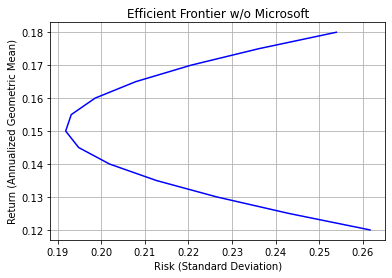

In [322]:
plt.plot(port_stds_wo_msft, port_returns_wo_msft, label='EF w/o Microsoft', color='b')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Efficient Frontier w/o Microsoft')
plt.grid()
plt.show()

To estimate the capital market line, we first need to know the risk free rate. This is given to be $\mu_0 = 2\%$ (0.02). We can compute the line as $\mu_{P}=\sigma_{P} \sqrt{\left(\boldsymbol{\mu}^{e}\right)^{\top}{\mathbf{\Sigma}}^{-1} \boldsymbol{\mu}^{e}}+\mu_{0}$ where $\sigma_{P}=\frac{\mu_{P}^{e}}{\sqrt{\left(\boldsymbol{\mu}^{e}\right)^{\top} \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}^{e}}}$ and $\boldsymbol{\mu}^{e}=\left[\mu_{1}-\mu_{0}, \mu_{2}-\mu_{0}, \ldots, \mu_{n}-\mu_{0}\right]^{\top}$. 

In [323]:
def compute_cpm(Sigma, mu, mu_p, mu_0):
    mu = np.expand_dims(mu, 1)
    mu_e = mu - mu_0
    mu_p_e = mu_p - mu_0
    weights = inv(Sigma) @ mu_e @ (mu_p_e / (mu_e.T @ inv(Sigma) @ mu_e))
    portfolio_std = mu_p_e / np.sqrt(mu_e.T @ inv(Sigma) @ mu_e)
    return weights, portfolio_std, mu_p

In [324]:
cpm_mu = np.arange(start=0.01, stop=0.5, step=0.01)
cpm_returns_wo_msft = np.array([])
cpm_stds_wo_msft = np.array([])
for portfolio_mu in cpm_mu:
    _, standard_dev, mu = compute_cpm(annual_cov_wo_msft, annual_mean_wo_msft, portfolio_mu, 0.02)
    cpm_returns_wo_msft = np.append(cpm_returns_wo_msft, mu)
    cpm_stds_wo_msft = np.append(cpm_stds_wo_msft, standard_dev)

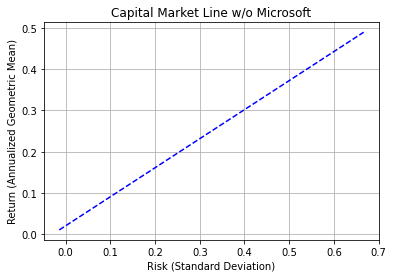

In [325]:
plt.plot(cpm_stds_wo_msft, cpm_returns_wo_msft, label='CPM Line w/o Microsoft', color='b', linestyle='--')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Capital Market Line w/o Microsoft')
plt.grid()
plt.show()

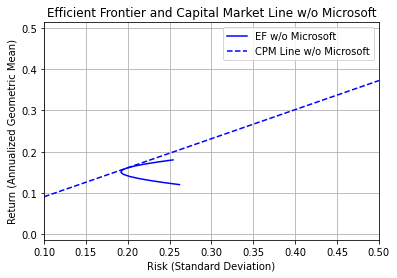

In [326]:
plt.plot(port_stds_wo_msft, port_returns_wo_msft, label='EF w/o Microsoft', color='b')
plt.plot(cpm_stds_wo_msft, cpm_returns_wo_msft, label='CPM Line w/o Microsoft', color='b', linestyle='--')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Efficient Frontier and Capital Market Line w/o Microsoft')
plt.legend()
plt.grid()
plt.xlim(0.10, 0.50)
plt.show()

#### b) Now add Microsoft to the portfolio and redo the previous question. Add the new efficient frontier and the CML to the same graph. Comment on your findings.

Now, we'll redo everything but where Microsoft is included in the portfolio. 

In [327]:
frontier_mu = np.arange(start=0.0, stop=0.8, step=0.005)
port_returns = np.array([])
port_stds = np.array([])
for portfolio_mu in frontier_mu:
    solution = compute_efficient_frontier(annual_cov, annual_mean, portfolio_mu)
    if solution is not None:
        _, standard_dev, mu = solution
        port_returns = np.append(port_returns, mu)
        port_stds = np.append(port_stds, standard_dev)

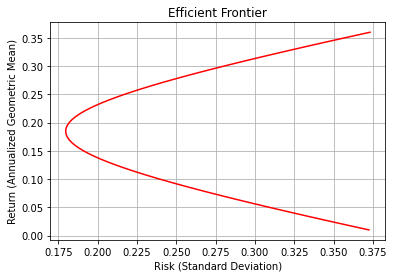

In [328]:
plt.plot(port_stds, port_returns, label='EF', color='r')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Efficient Frontier')
plt.grid()
plt.show()

In [329]:
cpm_mu = np.arange(start=0.0, stop=0.8, step=0.01)
cpm_returns = np.array([])
cpm_stds = np.array([])
for portfolio_mu in cpm_mu:
    _, standard_dev, mu = compute_cpm(annual_cov, annual_mean, portfolio_mu, 0.02)
    cpm_returns = np.append(cpm_returns, mu)
    cpm_stds = np.append(cpm_stds, standard_dev)

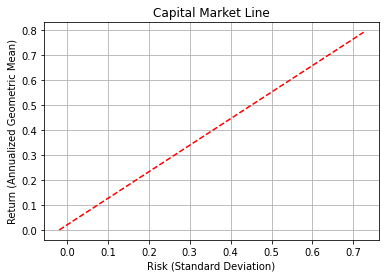

In [330]:
plt.plot(cpm_stds, cpm_returns, label='CPM Line', color='r', linestyle='--')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Capital Market Line')
plt.grid()
plt.show()

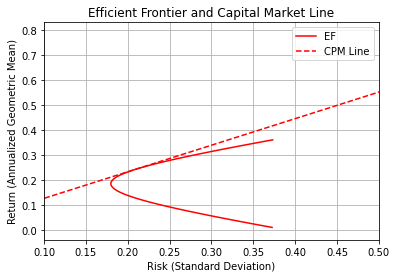

In [331]:
plt.plot(port_stds, port_returns, label='EF', color='r')
plt.plot(cpm_stds, cpm_returns, label='CPM Line', color='r', linestyle='--')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Efficient Frontier and Capital Market Line')
plt.legend()
plt.grid()
plt.xlim(0.1, 0.5)
plt.show()

Now we can plot the efficient frontiers and capital market line together into one plot. 

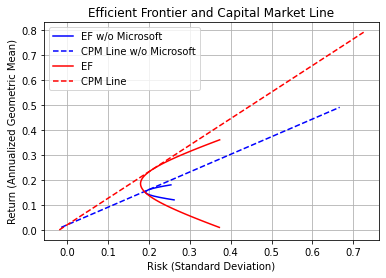

In [332]:
plt.plot(port_stds_wo_msft, port_returns_wo_msft, label='EF w/o Microsoft', color='b')
plt.plot(cpm_stds_wo_msft, cpm_returns_wo_msft, label='CPM Line w/o Microsoft', color='b', linestyle='--')
plt.plot(port_stds, port_returns, label='EF', color='r')
plt.plot(cpm_stds, cpm_returns, label='CPM Line', color='r', linestyle='--')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Efficient Frontier and Capital Market Line')
plt.legend()
plt.grid()
plt.show()

We see that when Microsoft is included into the portfolio (red frontier), the returns are much higher as well as a significantly lower risk for any given return $\mu_p$ compared to when Microsoft is not included (blue frontier). Moreover, the slope of the capital market line is greater when Microsoft is included which is expected based on the comparisons between the two efficient frontiers. Lastly, the efficient frontier that includes Microsoft continues further up, i.e. has possibilities for higher returns, than the other than doesn't. 

### 2. (Portfolios, diversification, efficient frontier)

To do this part, we'll have to do numerical optimization since there are no solutions in a closed form. Therefore, we'll use the minimze function from the scipe library. You can read the documentation for the whole scipy.optimize library at https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html. Or if you want to read how to optimize problems that are relevant to these exercises, this stackoverflow thread https://stackoverflow.com/questions/56448241/how-to-create-bound-in-scipy-optimize-so-optimizer-cant-reach-more-than-1-in-su shows a basic template on how to do get started. 

In [333]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

#### a) No bank account (risk-less lending) and no short selling allowed. Plot this in the same graph as with short selling allowed and comment on your findings

For this, we need to make sure that the weights are between 0 and 1 and that the weights sum up to one. The following function shows how one such optimization function could look like. 

In [334]:
def efficient_frontier_no_bankaccount_no_shorting(Sigma, mu, mu_p):
    
    # Sigma: Cov-Var Matrix
    # mu: Array of returns
    # mu_p: A given return
    
    # objective function (minimize variance)
    def object_function(weights):
        return weights.T @ Sigma @ weights
    
    # constraint: sum(weights) = 1
    def constraint_sum_to_1(weights):
        return 1 - np.sum(weights)
    
    def constraint_return_equal_mup(weights):
        return mu_p - np.sum(weights * mu)
    
    # constraint: sum(weights) = 1
    # constraint: sum(weights * mu) = mu_p
    cons   = ({'type':'eq','fun':constraint_sum_to_1},
             {'type':'eq','fun':constraint_return_equal_mup})

    # initial weights (uniform distribution)
    w0   = np.ones(len(mu))/len(mu)
    
    # define bounds
    bnds = ((0.0, 1.0),) * len(mu)
    
    # minimize
    sol  = minimize(object_function, w0, bounds = bnds, constraints = cons)
    
    # extract weights from solution
    w_opt = np.array(sol.x)
    portfolio_std = np.sqrt(w_opt.T @ Sigma @ w_opt)
    
    if sol.success:
        return w_opt, portfolio_std, mu_p
    else:
        return None

To compute the efficient frontier, we loop through a sequence of returns between 0 and 0.8 and stores the returns and standard deviation. 

In [335]:
mu_ps = np.arange(start=0.0, stop=0.8, step=0.01)
no_lend_no_short_returns = np.array([])
no_lend_no_short_stds = np.array([])
for portfolio_mu in mu_ps:
    solution = efficient_frontier_no_bankaccount_no_shorting(annual_cov, annual_mean, portfolio_mu)
    if solution is not None:
        _, standard_dev, mu = solution
        no_lend_no_short_returns = np.append(no_lend_no_short_returns, mu)
        no_lend_no_short_stds = np.append(no_lend_no_short_stds, standard_dev)

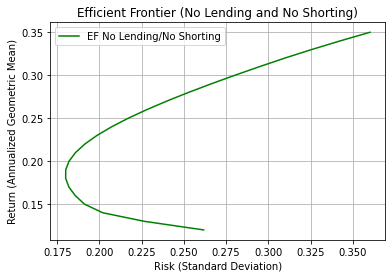

In [348]:
plt.plot(no_lend_no_short_stds, no_lend_no_short_returns, label='EF No Lending/No Shorting', color='g')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Efficient Frontier (No Lending and No Shorting)')
plt.legend()
plt.grid()
plt.show()

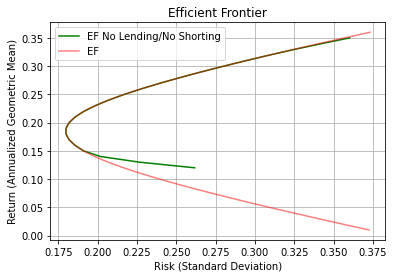

In [349]:
plt.plot(no_lend_no_short_stds, no_lend_no_short_returns, label='EF No Lending/No Shorting', color='g')
plt.plot(port_stds, port_returns, label='EF', color='r', alpha=0.5)
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Efficient Frontier')
plt.legend()
plt.grid()
plt.show()

We see that the two efficient frontiers are very much identical. The lower part deviates a lot but this part is of course not interesting. If you watch very closely, the efficient frontier that allows shorting does have slight better return but this difference is minimal. 

#### b) Risk-less lending is allowed and no short selling. Plot this in the same graph as above.

In this question, we will in the optimization add the risk free rate (rf) at 2% to the constraint that makes sure that the weighted return equals $\mu_p$. Other than that, the optimization function stays the same. Though, note the indexing of the weights in the objective function and constraints. This is because the weight array is increased with 1, where the last element represents the weight for lending, while $\Sigma$ and $\mu$ stays the same as before. 

In [343]:
def efficient_frontier_with_lending_no_shorting(Sigma, mu, mu_p):
    
    rf = 0.02
    # objective function (minimize variance)
    def object_function(weights):
        return weights[:-1].T @ Sigma @ weights[:-1]
    
    # constraint: sum(weights) = 1
    def constraint_sum_to_1(weights):
        return 1 - ( np.sum(weights[:-1]) + weights[-1] )
    
    def constraint_return_equal_mup(weights):
        return mu_p - ( np.sum(weights[:-1] * mu) + weights[-1] * rf )
    
    # constraint: sum(weights) = 1
    cons   = ({'type':'eq','fun':constraint_sum_to_1},
             {'type':'eq','fun':constraint_return_equal_mup})

    # initial weights (uniform distribution)
    w0   = np.ones(len(mu) + 1)/(len(mu) + 1)
    
    # define bounds
    bnds = ((0.0, 1.0),) * (len(mu) + 1)
    
    # minimize
    sol  = minimize(object_function, w0, bounds = bnds, constraints = cons)
    
    # extract weights from solution
    w_opt = np.array(sol.x)
    portfolio_std = np.sqrt(w_opt[:-1].T @ Sigma @ w_opt[:-1])
    
    if sol.success:
        return w_opt, portfolio_std, mu_p
    else:
        return None

In [345]:
mu_ps = np.arange(start=0.0, stop=0.8, step=0.01)
lending_no_short_returns = np.array([])
lending_no_short_stds = np.array([])
for portfolio_mu in mu_ps:
    solution = efficient_frontier_with_lending_no_shorting(annual_cov, annual_mean, portfolio_mu)
    if solution is not None:
        _, standard_dev, mu = solution
        lending_no_short_returns = np.append(lending_no_short_returns, mu)
        lending_no_short_stds = np.append(lending_no_short_stds, standard_dev)

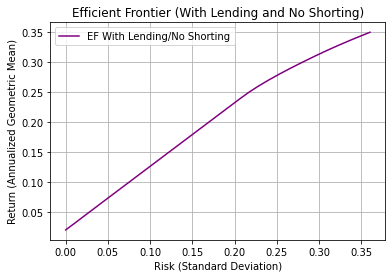

In [347]:
plt.plot(lending_no_short_stds, lending_no_short_returns, label='EF With Lending/No Shorting', color='purple')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Efficient Frontier (With Lending and No Shorting)')
plt.legend()
plt.grid()
plt.show()

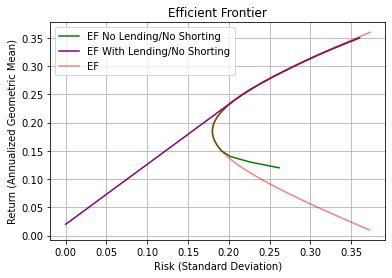

In [350]:
plt.plot(no_lend_no_short_stds, no_lend_no_short_returns, label='EF No Lending/No Shorting', color='g')
plt.plot(lending_no_short_stds, lending_no_short_returns, label='EF With Lending/No Shorting', color='purple')
plt.plot(port_stds, port_returns, label='EF', color='r', alpha=0.5)
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Efficient Frontier')
plt.legend()
plt.grid()
plt.show()

THe purple efficient frontier, which shows the frontier that allows lending and no shorting, is very different from the others. The reason for this is bceause wee allow this frontier to lend money out to a risk free rate. Thus, the risk of the frontier goes to 0 with a return of 0.02 (risk free rate). Moreover, the last upper part of the frontier is also very similar to EF as we saw with the previous frontier. 

#### c) No more than 1/2 of the wealth invested in each asset

In this exercise, we have to make sure that all weights are between 0 and 1/2. Moreover, even when it's not direectly stated, shorting and lending is again not allowed. Thus, the constraints from question a) are the same just with the slight modification of the boundary of the weights. 

In [351]:
def efficient_frontier_max_half_allocation_no_bankaccount_no_shorting(Sigma, mu, mu_p):
    
    # objective function (minimize variance)
    def object_function(weights):
        return weights.T @ Sigma @ weights
    
    # constraint: sum(weights) = 1
    def constraint_sum_to_1(weights):
        return 1 - np.sum(weights)
    
    def constraint_return_equal_mup(weights):
        return mu_p - np.sum(weights * mu)
    
    # constraint: sum(weights) = 1
    cons   = ({'type':'eq','fun':constraint_sum_to_1},
             {'type':'eq','fun':constraint_return_equal_mup})

    # initial weights (uniform distribution)
    w0   = np.ones(len(mu))/len(mu)
    
    # define bounds
    bnds = ((0.0, 0.5),) * len(mu)
    
    # minimize
    sol  = minimize(object_function, w0, bounds = bnds, constraints = cons)

    # extract weights from solution
    w_opt = np.array(sol.x)
    portfolio_std = np.sqrt(w_opt.T @ Sigma @ w_opt)
    
    if sol.success:
        return w_opt, portfolio_std, mu_p
    else:
        return None

In [352]:
mu_ps = np.arange(start=0.0, stop=0.8, step=0.01)
maxhalf_no_lend_no_short_returns = np.array([])
maxhalf_no_lend_no_short_stds = np.array([])
for portfolio_mu in mu_ps:
    solution = efficient_frontier_max_half_allocation_no_bankaccount_no_shorting(annual_cov, annual_mean, portfolio_mu)
    if solution is not None:
        _, standard_dev, mu = solution
        maxhalf_no_lend_no_short_returns = np.append(maxhalf_no_lend_no_short_returns, mu)
        maxhalf_no_lend_no_short_stds = np.append(maxhalf_no_lend_no_short_stds, standard_dev)

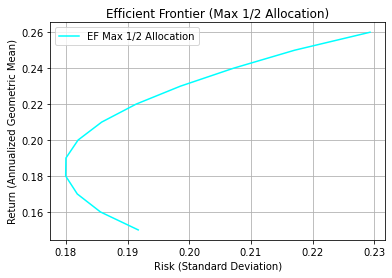

In [353]:
plt.plot(maxhalf_no_lend_no_short_stds, maxhalf_no_lend_no_short_returns, label='EF Max 1/2 Allocation', color='cyan')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Efficient Frontier (Max 1/2 Allocation)')
plt.legend()
plt.grid()
plt.show()

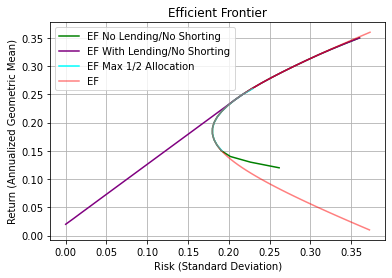

In [354]:
plt.plot(no_lend_no_short_stds, no_lend_no_short_returns, label='EF No Lending/No Shorting', color='g')
plt.plot(lending_no_short_stds, lending_no_short_returns, label='EF With Lending/No Shorting', color='purple')
plt.plot(maxhalf_no_lend_no_short_stds, maxhalf_no_lend_no_short_returns, label='EF Max 1/2 Allocation', color='cyan')
plt.plot(port_stds, port_returns, label='EF', color='r', alpha=0.5)
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return (Annualized Geometric Mean)')
plt.title('Efficient Frontier')
plt.legend()
plt.grid()
plt.show()

As before, we see that the latest frontier is similar to the others 